In [2]:
import sys
sys.path.append('../')

In [3]:
import pennylane as qml 
from pennylane import numpy as np 
import matplotlib.pyplot as plt 
from main import arbitrary_state, VarFourier
import numpy

(-8.0, 8.0)

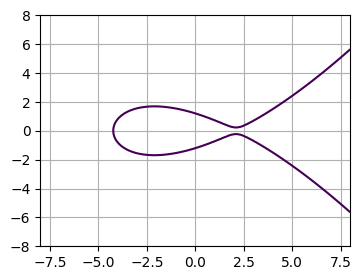

In [4]:
a = 0.075
b = -1
c = 1.4575131
m = 1/2

y, x = numpy.ogrid[-8:8:100j, -8:8:100j]
plt.figure( figsize=(4,3) )
plt.contour( x.ravel(), y.ravel(), 
            y**2 - a*x**3 - b *x  - c, [0] )
plt.grid()
plt.xlim( -8, 8)
plt.ylim( -8, 8)

In [5]:
num_qubits = 4

In [6]:
def init_state():
    pass 
    # for k in range(num_qubits):
    #     qml.PauliX(k)

In [7]:
num_layers = 1
var_state_class = arbitrary_state(num_qubits,num_layers)
var_state = var_state_class.construct_circuit

num_params = var_state_class.num_params
num_params

16

(<Figure size 400x500 with 1 Axes>, <Axes: >)

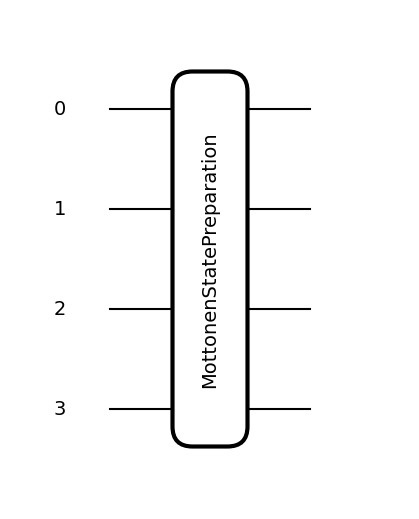

In [8]:
qml.draw_mpl( var_state )( num_params*[1] )

In [9]:
device = qml.device( "lightning.qubit", 
                    wires=num_qubits,
                    shots=100)

varqft = VarFourier( num_qubits,
                    lambda x : ( -a*x**3 - b*x ),
                    lambda p : p**2/(2*m),
                    device,
                    var_state  = var_state,
                    init_state = init_state,
                    xmin=-8,
                    xmax= 8,
                    tarjet_energy = c 
                    )

In [10]:
vals, vecs = varqft.energy_eigens()
idx_tarjet = np.argmin( np.abs( c- np.array(vals) ) )
val = vals[idx_tarjet]
vec = vecs[:,idx_tarjet]
val, c, vals

(1.457513154235416,
 1.4575131,
 array([-27.79260848, -15.28648178,  -6.56168902,  -0.97264387,
         -0.73600821,   0.51523772,   1.45751315,   1.97831701,
          2.90012671,   3.94585948,   5.1244897 ,   6.80418158,
          8.04011511,  12.43873508,  21.10736643,  33.66269573]))

In [11]:
varqft.energy_eval( vec )

c:\Users\lucia\miniconda3\envs\pennylane\Lib\site-packages\pennylane\_qubit_device.py:551: UserWarning: Requested measurement MyMP with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


2.9389513203425987e-15

In [12]:
np.random.seed(103)
params_init = vec.real + np.random.randn( num_params )*0.1
params_init = params_init / np.linalg.norm( params_init )
varqft.energy_eval( params_init )

0.23197399185550496

In [13]:
params_ground, energies_ground = varqft.run( params_init, 
                                            max_iterations = 100, 
                                            learning_rate  = 0.1,
                                            postprocessing = lambda x : x/np.linalg.norm(x),
                                            step_print=1 )

Step = 0,  Energy = 4.62364960
Step = 1,  Energy = 0.70423746
Step = 2,  Energy = 0.19918117
Step = 3,  Energy = 0.22512531
Step = 4,  Energy = 0.53425181
Step = 5,  Energy = 1.37107682
Step = 6,  Energy = 2.63587713
Step = 7,  Energy = 2.26936412
Step = 8,  Energy = 1.28824878
Step = 9,  Energy = 0.79189181
Step = 10,  Energy = 0.80026335
Step = 11,  Energy = 1.17063630
Step = 12,  Energy = 1.70995939
Step = 13,  Energy = 2.04275012
Step = 14,  Energy = 1.93194985
Step = 15,  Energy = 1.57595003
Step = 16,  Energy = 1.26089323
Step = 17,  Energy = 1.10867989
Step = 18,  Energy = 1.12419689
Step = 19,  Energy = 1.27011251
Step = 20,  Energy = 1.48200428
Step = 21,  Energy = 1.66672254
Step = 22,  Energy = 1.73560297
Step = 23,  Energy = 1.66656435
Step = 24,  Energy = 1.51716816
Step = 25,  Energy = 1.36956918
Step = 26,  Energy = 1.27966642
Step = 27,  Energy = 1.26748502
Step = 28,  Energy = 1.32708466
Step = 29,  Energy = 1.43281996
Step = 30,  Energy = 1.54174948
Step = 31,  Energy

In [14]:
np.min(energies_ground)

0.19918116927146912

c:\Users\lucia\miniconda3\envs\pennylane\Lib\site-packages\pennylane\_qubit_device.py:653: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


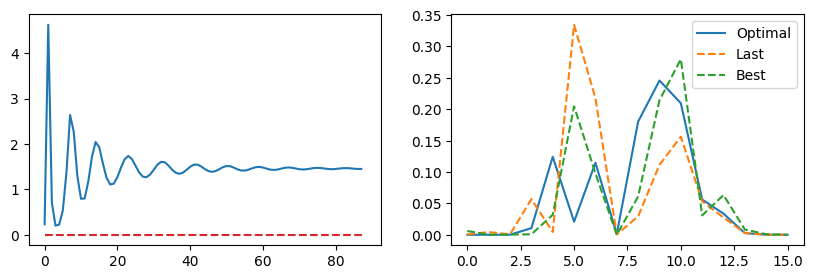

In [15]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot( energies_ground )
ax[0].hlines( 0, 0, len(energies_ground), colors='tab:red', linestyles='--' ) 

ground_state = varqft.state( params_ground[np.argmin(energies_ground)] )
last_state = varqft.state( params_ground[-1] )

ax[1].plot( np.abs(vec)**2) 
ax[1].plot( np.abs(last_state)**2, '--' ) 
ax[1].plot( np.abs(ground_state)**2, '--' ) 
ax[1].legend(['Optimal','Last','Best']) 

In [16]:
fid = np.abs( vecs.T.conj()@ground_state )**2
fid, fid[idx_tarjet]

(tensor([1.1339547e-04, 2.6583222e-03, 4.9452174e-05, 7.1161939e-03,
         2.2235660e-02, 1.5659813e-02, 8.2026428e-01, 2.8010111e-02,
         1.3629740e-02, 1.7061211e-02, 4.9281217e-02, 8.3583677e-03,
         8.8473456e-03, 5.7027180e-05, 3.7477669e-06, 6.6542011e-03],
        dtype=float32, requires_grad=True),
 tensor(0.8202643, dtype=float32, requires_grad=True))

In [17]:
fid = np.abs( vecs.T.conj()@last_state )**2
fid, fid[idx_tarjet]

(tensor([3.5954406e-05, 1.8004917e-04, 8.5419206e-06, 4.9711452e-05,
         6.6155642e-03, 3.8687892e-02, 5.5766594e-01, 1.9282721e-02,
         3.3139732e-02, 1.7809400e-01, 1.3853598e-01, 1.7054394e-03,
         2.0640215e-02, 2.2541157e-04, 4.9963174e-03, 1.3634526e-04],
        dtype=float32, requires_grad=True),
 tensor(0.55766594, dtype=float32, requires_grad=True))